In [3]:
from zamboni import DBConnector, Exporter
from zamboni.pd_helpers import filter_by_game_type, filter_by_season, filter_by_team, won_by_team, _wins_game
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [4]:
db_con = DBConnector('../data/zamboni.db')
conn = db_con.connect_db()

In [3]:
sql = 'SELECT * FROM games INNER JOIN teams home_teams ON games.homeTeamID = home_teams.id INNER JOIN teams away_teams ON games.awayTeamID = away_teams.id'
teams_sql = 'SELECT * FROM teams'

In [4]:
df = pd.read_sql(sql, conn)
teams_info_df = pd.read_sql(teams_sql, conn)

In [5]:
print(teams_info_df)

    id apiID                   name nameAbbrev conferenceAbbrev divisionAbbrev
0    1  None       New York Rangers        NYR                E              M
1    2  None           Dallas Stars        DAL                W              C
2    3  None    Carolina Hurricanes        CAR                E              M
3    4  None          Winnipeg Jets        WPG                W              C
4    5  None       Florida Panthers        FLA                E              A
5    6  None      Vancouver Canucks        VAN                W              P
6    7  None          Boston Bruins        BOS                E              A
7    8  None     Colorado Avalanche        COL                W              C
8    9  None        Edmonton Oilers        EDM                W              P
9   10  None    Toronto Maple Leafs        TOR                E              A
10  11  None    Nashville Predators        NSH                W              C
11  12  None      Los Angeles Kings        LAK      

In [6]:
print(df.iloc[0])

id                                    1
apiID                        2019030215
seasonID                       20192020
homeTeamID                           21
awayTeamID                           15
datePlayed                   2020-09-01
timePlayed                     23:00:00
homeTeamGoals                         4
awayTeamGoals                         3
gameTypeID                            3
lastPeriodTypeID                     OT
outcome                               1
id                                   21
apiID                              None
name                Philadelphia Flyers
nameAbbrev                          PHI
conferenceAbbrev                      E
divisionAbbrev                        M
id                                   15
apiID                              None
name                 New York Islanders
nameAbbrev                          NYI
conferenceAbbrev                      E
divisionAbbrev                        M
Name: 0, dtype: object


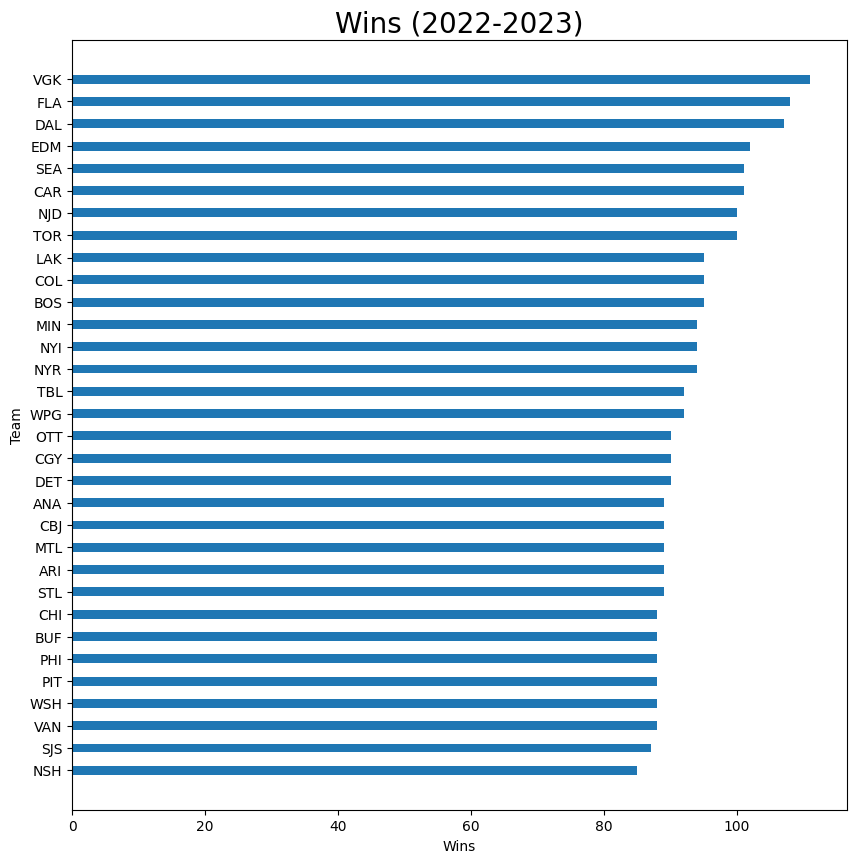

In [17]:
fig, ax = plt.subplots(figsize=(10,10))

season_id = 20222023

season_df = filter_by_season(df, season_id)
team_ids = list(set(season_df['homeTeamID']))
records = []

for team_id in team_ids:
    team_df = filter_by_team(season_df, team_id)
    wins = team_df.apply(_wins_game, args=(team_id,), axis=1)
    abbrev = teams_info_df[teams_info_df['id'] == team_id]['nameAbbrev'].values[0]
    records += [[abbrev, len(wins)]]

records = sorted(records, reverse=False, key=lambda x:x[1])
abbrevs = [record[0] for record in records]
wins = [record[1] for record in records]
ys = [2*i for i in range(len(records))]
plt.barh(ys, wins)
plt.yticks(ys, abbrevs)
plt.title('Wins (2022-2023)', size=20)
plt.ylabel('Team')
plt.xlabel('Wins')
plt.show()

In [ ]:
a_df = filter_by_team(df, 1)
a_df = filter_by_game_type(a_df, 2)
a_df = filter_by_season(a_df, 20222023)
#a_df = won_by_team(a_df, 1)
print(len(a_df))
print(a_df)

In [21]:
fil_df = a_df
fil_df['Won'] = df.apply(_wins_game, axis=1)
fil_df['Lost'] = ~fil_df['Won']
fil_df['WonLast'] = fil_df['Won'].shift(1)
fil_df['WonNext'] = fil_df['Won'].shift(-1)
fil_df['WonAndNext'] = fil_df['Won'] & fil_df['WonNext']
fil_df['LostWonNext'] = fil_df['Lost'] & fil_df['WonNext']

In [22]:
print(fil_df.iloc[0])

id                                 6169
apiID                        2022020003
seasonID                       20222023
homeTeamID                            1
awayTeamID                           13
datePlayed                   2022-10-11
timePlayed                     23:30:00
homeTeamGoals                         3
awayTeamGoals                         1
gameTypeID                            2
lastPeriodTypeID                    REG
outcome                               1
id                                    1
apiID                              None
name                   New York Rangers
nameAbbrev                          NYR
conferenceAbbrev                      E
divisionAbbrev                        M
id                                   13
apiID                              None
name                Tampa Bay Lightning
nameAbbrev                          TBL
conferenceAbbrev                      E
divisionAbbrev                        A
Won                                True


In [23]:
print(f'Games: {len(fil_df)}')
print(f'Wins: {sum(fil_df["Won"])}')
print(sum(fil_df['Won'])/len(fil_df))

Games: 82
Wins: 47
0.573170731707317


In [24]:
print(sum(fil_df[:-1]['WonAndNext']) / sum(fil_df[:-1]['Won']))
print(sum(fil_df[:-1]['LostWonNext']) / sum(fil_df[:-1]['Lost']))

0.574468085106383
0.5588235294117647


In [13]:
sql = 'SELECT gameID, '\
        'teamID, '\
		'seasonID, '\
		'won, '\
        'COUNT(*) AS prevGames, '\
		'CAST(SUM(prevWon) AS REAL) / COUNT(*) AS prevWonPercentage, '\
        'CAST(SUM(prevGoals) AS REAL) / COUNT(*) AS prevGoalsScoredPerGame, '\
        'CAST(SUM(prevOppGoals) AS REAL) / COUNT(*) AS prevGoalsAgainstPerGame, '\
		'SUM(prevWon), '\
		'SUM(prevGoals), '\
		'SUM(prevOppGoals), '\
		'COUNT(*) '\
	'FROM games_with_previous '\
    'WHERE teamID=1 '\
    'AND seasonID=20202021 '\
	'GROUP BY gameID, seasonID'

In [14]:
df = pd.read_sql(sql, conn)

In [15]:
print(df)

    gameID  teamID  seasonID  won  prevGames  prevWonPercentage  \
0      165       1  20202021    1          1           0.000000   
1      185       1  20202021    0          2           0.500000   
2      204       1  20202021    0          3           0.333333   
3      221       1  20202021    0          4           0.250000   
4      229       1  20202021    0          5           0.200000   
5      244       1  20202021    1          6           0.166667   
6      258       1  20202021    0          7           0.285714   
7      277       1  20202021    1          8           0.250000   
8      292       1  20202021    1          9           0.333333   
9      316       1  20202021    0         10           0.400000   
10     329       1  20202021    0         11           0.363636   
11     341       1  20202021    0         12           0.333333   
12     366       1  20202021    0         13           0.307692   
13     375       1  20202021    1         14           0.28571